In [157]:
import os
import csv
import pandas as pd
import numpy as np
from IPython.display import clear_output
import ast
import pymongo as pm
from datetime import datetime


### Set db connection and collection names

In [158]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the stanford-cogsci.org user
pswd = auth.values[0][0]
conn = pm.MongoClient('mongodb://stanford:' + pswd + '@127.0.0.1')
db = conn['kiddraw']

In [159]:
## for cdm_run_v4
# which_run = 'cdm_run_v4'
# invalid_draw_coll = db['invalid_draw_test']
# image_check_coll = db['check_invalid_cdm_run_v4']


## for cdm_run_v5
# which_run = 'cdm_run_v5'
# invalid_draw_coll = db['invalid_draw_cdm_run_v5']
# image_check_coll = db['check_invalid_cdm_run_v5_production']

# ## for cdm_run_v6
# which_run = 'cdm_run_v6'
# invalid_draw_coll = db['invalid_draw_cdm_run_v6']
# image_check_coll = db['check_invalid_cdm_run_v6_production']
# 
# ## for cdm_run_v7
which_run = 'cdm_run_v7'
invalid_draw_coll = db['invalid_draw_cdm_run_v7']
image_check_coll = db['check_invalid_cdm_run_v7_production']

In [160]:
# for w in actual_workers:
#     print(w=='5f556a46f0b6e193e149d8b8') # said they didn't get a completion code...

In [161]:
# time_threshold = datetime(2020, 9, 3, 1, 15) # when we started running mturk exp
time_threshold = datetime(2020, 9, 10, 13, 0) # when we started running prolific exp



In [216]:
image_paths = []
worker_ids=[]
bad_workers = []

invalid_draw_colls = ['invalid_draw_test','invalid_draw_cdm_run_v5', 'invalid_draw_cdm_run_v6','invalid_draw_cdm_run_v7']
# invalid_draw_colls = ['invalid_draw_cdm_run_v5']

for this_coll in invalid_draw_colls:
    invalid_draw_coll = db[this_coll]
    print(invalid_draw_coll)
    actual_workers = invalid_draw_coll.find({'date':{'$gt': time_threshold}}).distinct('worker_id')
    print (np.size(actual_workers))

    for w in actual_workers:
        entries = invalid_draw_coll.find({'worker_id': w})
        bad_drawings = entries.count()
#         print (w, bad_drawings)
        if (bad_drawings>=96):
            print ('exclduing', w)
            bad_workers.append(w)
        if (bad_drawings<96): # kick out workers who rated more than half of all shown drawings as bad...
            for e in entries:
                worker_ids.append(w)
                image_paths.append(e['filename'])

Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'kiddraw'), 'invalid_draw_test')
101


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:16: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  app.launch_new_instance()


exclduing 59b859e711212f0001cd10ff
exclduing 5f286aafb66d30178ab62e82
exclduing 5e2cbee9eb557a2dee97613b
exclduing 5f514511a0830d35cbe96f0d
exclduing 5f58f0f17723ca0aa7e5a225
exclduing 5eb059cdacc7110f441bad41
Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'kiddraw'), 'invalid_draw_cdm_run_v5')
97
Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'kiddraw'), 'invalid_draw_cdm_run_v6')
109
exclduing 595b93cde11c9d0001522564
exclduing 5f479154dc1bde17b64d7eb5
exclduing 5f4cb77384ba278c4622af23
exclduing 5f5518382b50e98b39669dca
exclduing 5f556a46f0b6e193e149d8b8
exclduing 5f074c9c163ead339b59e695
exclduing 5f4cd7086e1f3e8e7b7bca87
Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'kiddraw'), 'invalid_draw_cdm_run_v7')
91


In [217]:
np.size(image_paths)

15562

In [222]:
np.size(np.unique(image_paths))

10303

In [220]:
np.size(np.unique(worker_ids))

385

In [221]:
np.size(np.unique(bad_workers))

13

In [218]:
#  for reach run separately...
# image_paths = []
# worker_ids=[]
# bad_workers = []

# for w in actual_workers:
#     entries = invalid_draw_coll.find({'worker_id': w})
#     bad_drawings = entries.count()
#     print (w, bad_drawings)
#     if (bad_drawings>=96):
#         print ('exclduing', w)
#         bad_workers.append(w)
#     if (bad_drawings<96): # kick out workers who rated more than half of all shown drawings as bad...
#         for e in entries:
#             worker_ids.append(w)
#             image_paths.append(e['filename'])

In [163]:

exclude_ids = '5b5cab744e945800017d9daf' # reported they selected all "horse" drawings
to_check = pd.DataFrame(image_paths, worker_ids)
filename = 'filtering_outputs/' + 'marked_invalid_drawings_' +  which_run + '.csv'
to_check.to_csv(filename)

In [164]:
to_check.to_csv(filename)

In [165]:
# suspicious = coll.find({'worker_id': '5e9e20015361b91c9cb42bb3'})
# image_paths = []
# for s in suspicious:
#     image_paths.append(s['filename'])
    

# # for rendering out in R

### Now get df with all images in this collection and whether they have been processed in a hit

In [198]:
images_to_check = image_check_coll.find({'class':{'$exists':True}})
images_df = pd.DataFrame(images_to_check)

In [199]:
image_check_coll

Collection(Database(MongoClient(host=['127.0.0.1:27017'], document_class=dict, tz_aware=False, connect=True), 'kiddraw'), 'check_invalid_cdm_run_v7_production')

In [200]:
images_df = images_df.assign(numGames = images_df.apply(lambda x: len(x['games']), axis=1))


In [201]:
filename_images = 'filtering_outputs/' + 'images_checked_' + which_run + '.csv'
images_df.to_csv(filename_images)

In [202]:
filename_images

'filtering_outputs/images_checked_cdm_run_v7.csv'

### check distributions of how many times images have been seen

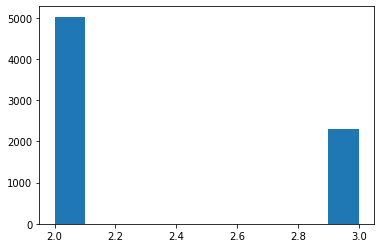

In [197]:
from matplotlib import pyplot
%matplotlib inline
plt = pyplot
h = plt.hist(images_df['numGames'].values)

In [184]:
images_df.sort_values(by='shuffler_ind', inplace=True)

In [185]:
print(images_df['shuffler_ind'].values)

[   0    1    2 ... 7330 7331 7332]


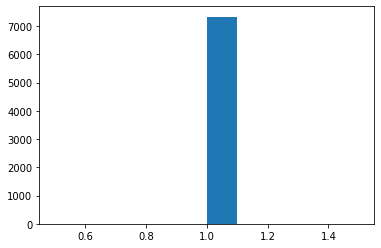

In [134]:
## make sure we don't have duplicate shuffler_inds
from collections import Counter
h = plt.hist(Counter(images_df['shuffler_ind'].values).values())#

In [109]:
## is it really the case that the number of unique shuffler_inds matches the size of the df???
assert np.max(images_df['shuffler_ind'].values)==len(images_df)-1

In [59]:
# time_threshold = datetime(2020, 8, 19, 10, 15) # when we started running mturk exp
# coll_recent = coll.find({'updatedAt':{'$gt': time_threshold}})

In [138]:
# coll_recent[0]

In [ ]:
## wipe games in current collection